## Import Necessary Libraries


In [1]:
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder

## Merging and Cleaning Housing Data


In [3]:
data_one = pd.read_csv("data/raw_data/2000to2012.csv")
data_two = pd.read_csv("data/raw_data/2012to2014.csv")
data_three = pd.read_csv("data/raw_data/jan2015toDec2016.csv")
data_four = pd.read_csv("data/raw_data/jan2017upwards.csv")

data_one = data_one.drop(columns=["block", "street_name"])
data_two = data_two.drop(columns=["block", "street_name"])
data_three = data_three.drop(columns=["block", "street_name","remaining_lease"])
data_four = data_four.drop(columns=["block", "street_name","remaining_lease"])

combined_data = pd.concat([data_one, data_two, data_three, data_four], ignore_index=True)

sorted_combined_data = combined_data.sort_values(by='month', ascending=True)

sorted_combined_data

,month,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2000-01,ANG MO KIO,3 ROOM,07 TO 09,69.0,Improved,1986,147000.0
1588,2000-01,QUEENSTOWN,3 ROOM,04 TO 06,66.0,Improved,1970,145000.0
1589,2000-01,QUEENSTOWN,3 ROOM,16 TO 18,72.0,Improved,1970,208000.0
1590,2000-01,QUEENSTOWN,3 ROOM,04 TO 06,72.0,Improved,1970,186000.0
1591,2000-01,QUEENSTOWN,3 ROOM,01 TO 03,72.0,Improved,1970,182000.0
...,...,...,...,...,...,...,...,...
633288,2024-03,HOUGANG,4 ROOM,01 TO 03,105.0,Model A,1990,538888.0
633289,2024-03,HOUGANG,4 ROOM,10 TO 12,91.0,New Generation,1985,538000.0
633290,2024-03,HOUGANG,4 ROOM,07 TO 09,98.0,New Generation,1978,538000.0
633276,2024-03,HOUGANG,4 ROOM,04 TO 06,92.0,Model A,2019,573000.0


In [4]:
sorted_combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 634002 entries, 0 to 634001
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                634002 non-null  object 
 1   town                 634002 non-null  object 
 2   flat_type            634002 non-null  object 
 3   storey_range         634002 non-null  object 
 4   floor_area_sqm       634002 non-null  float64
 5   flat_model           634002 non-null  object 
 6   lease_commence_date  634002 non-null  int64  
 7   resale_price         634002 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 43.5+ MB


In [5]:
cols = sorted_combined_data.columns.tolist()  # Convert column names to a list
cols = cols[-2:] + cols[:-2]
sorted_combined_data = sorted_combined_data[cols]
sorted_combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 634002 entries, 0 to 634001
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   lease_commence_date  634002 non-null  int64  
 1   resale_price         634002 non-null  float64
 2   month                634002 non-null  object 
 3   town                 634002 non-null  object 
 4   flat_type            634002 non-null  object 
 5   storey_range         634002 non-null  object 
 6   floor_area_sqm       634002 non-null  float64
 7   flat_model           634002 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 43.5+ MB


## Data Manipulation Summary

### 1. Copy of DataFrame
A copy of `sorted_combined_data` is created and assigned to `merged_data`. This step is important to avoid altering the original DataFrame during data manipulation processes.

### 2. Extract Year and Month
The `year` and `month` are extracted from a column named `month` in the DataFrame. This is achieved by:
- Splitting the string on the hyphen (`-`).
- Converting each split string to numeric form.
The resulting year and month are then stored in new columns labeled `Year` and `Month`, respectively.

### 3. Processing Storey Range
The storey range (e.g., "7 TO 9") is processed by:
- Extracting numeric values from the `storey_range` column using a regular expression.
- Converting these numeric values to float, representing the lower and upper floors.
- Calculating an `average_storey` column as the mean of these lower and upper storey values.

### 4. Selecting Specific Columns
Only specific columns are retained in the DataFrame, including:
- `Year`, `Month`, `lease_commence_date`, `floor_area_sqm`, `average_storey`, `town`, `flat_type`, `flat_model`, `resale_price`.

### 5. Display Initial Rows
The first few rows of the updated `merged_data` DataFrame are displayed using the `head()` method to provide a quick overview of the modifications.


In [6]:
import pandas as pd

# Assuming sorted_combined_data is already defined
merged_data = sorted_combined_data.copy()  # Create a copy to ensure you are not modifying the original DataFrame
merged_data['Year'] = pd.to_numeric(merged_data['month'].str.split('-').str[0])
merged_data['Month'] = pd.to_numeric(merged_data['month'].str.split('-').str[1])

# Changing 7 to 9 floor into average of 8th floor
storey_range_df = merged_data['storey_range'].str.extract(r'(\d+) TO (\d+)').astype(float)
merged_data['lower_storey'] = storey_range_df[0]
merged_data['upper_storey'] = storey_range_df[1]
merged_data['average_storey'] = (merged_data['lower_storey'] + merged_data['upper_storey']) / 2

# Selecting specific columns to keep in the DataFrame
merged_data = merged_data[['Year', 'Month', 'lease_commence_date', 'floor_area_sqm', 'average_storey', 'town', 'flat_type', 'flat_model', 'resale_price']]

merged_data.head()

,Year,Month,lease_commence_date,floor_area_sqm,average_storey,town,flat_type,flat_model,resale_price
0,2000,1,1986,69.0,8.0,ANG MO KIO,3 ROOM,Improved,147000.0
1588,2000,1,1970,66.0,5.0,QUEENSTOWN,3 ROOM,Improved,145000.0
1589,2000,1,1970,72.0,17.0,QUEENSTOWN,3 ROOM,Improved,208000.0
1590,2000,1,1970,72.0,5.0,QUEENSTOWN,3 ROOM,Improved,186000.0
1591,2000,1,1970,72.0,2.0,QUEENSTOWN,3 ROOM,Improved,182000.0


In [9]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 634002 entries, 0 to 634001
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Year                 634002 non-null  int64  
 1   Month                634002 non-null  int64  
 2   lease_commence_date  634002 non-null  int64  
 3   floor_area_sqm       634002 non-null  float64
 4   average_storey       634002 non-null  float64
 5   town                 634002 non-null  object 
 6   flat_type            634002 non-null  object 
 7   flat_model           634002 non-null  object 
 8   resale_price         634002 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 48.4+ MB


In [10]:
encoding_mappings = {}

numerical_data = merged_data.select_dtypes(include=['float64', 'int64','int32'])
categorical_columns = merged_data.select_dtypes(include=['object']).columns.tolist()

encoded_data = merged_data.copy()
for column in categorical_columns:

    mean_prices = merged_data.groupby(column)['resale_price'].median().sort_values()
    rank = {category: rank for rank, category in enumerate(mean_prices.index, 0)}
    
    encoding_mappings[column] = rank
    encoded_data[column] = merged_data[column].map(rank)

final_data = pd.concat([numerical_data, encoded_data[categorical_columns]], axis=1)

final_data = final_data[['Year', 'Month', 'lease_commence_date', 'floor_area_sqm', 'average_storey', 'town', 'flat_type', 'flat_model', 'resale_price']]
final_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 634002 entries, 0 to 634001
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Year                 634002 non-null  int64  
 1   Month                634002 non-null  int64  
 2   lease_commence_date  634002 non-null  int64  
 3   floor_area_sqm       634002 non-null  float64
 4   average_storey       634002 non-null  float64
 5   town                 634002 non-null  int64  
 6   flat_type            634002 non-null  int64  
 7   flat_model           634002 non-null  int64  
 8   resale_price         634002 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 48.4 MB


# Correlation Heatmap Explanation

### This heatmap visualizes the correlation coefficients between different variables in a dataset. The values range from -1.0 to 1.0, where:

- `1.0` indicates a perfect positive correlation.
- `0` indicates no correlation.
- `-1.0` indicates a perfect negative correlation.

### The colors in the heatmap correspond to the strength of the correlation:

- `Red` tones suggest a positive correlation.
- `Blue` tones suggest a negative correlation.
- `White` or `light shades` indicate a very weak or no correlation.

### Observations:

- The `resale_price` shows a moderate positive correlation with `Year` (0.65), indicating that resale prices may tend to increase over the years.
- A strong positive correlation exists between `floor_area_sqm` and `average_storey` (0.95), which might suggest that larger floor areas are typically found on higher floors, or vice versa.
- The `floor_area_sqm` also has a moderate positive correlation with `resale_price` (0.52), which could imply that larger apartments tend to sell for higher prices.
- The variables `Month` and `town` show little to no correlation with the other variables, as indicated by the predominantly white color in their corresponding rows and columns.





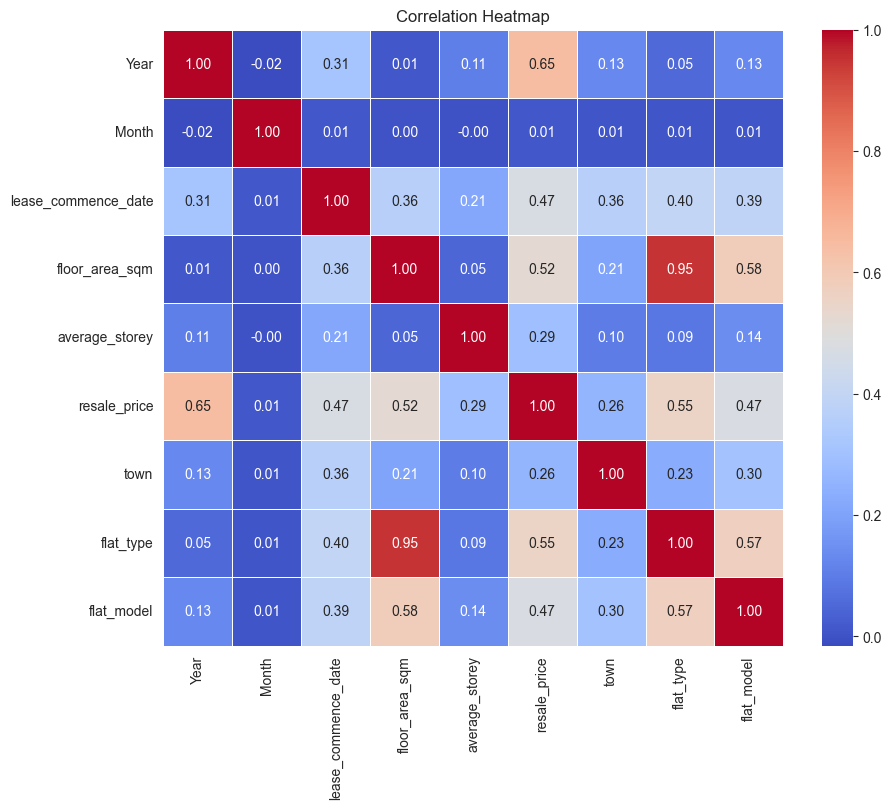

In [56]:
corr = final_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.xticks(rotation=90)  

plt.show()

In [57]:
final_data = final_data.drop(columns='Month')

## Histogram Analysis

### Histogram of floor_area_sqm

- **Description:** This histogram displays the distribution of `floor_area_sqm` values.
- **Skewness:** 0.30, indicating a slight right skew in the data, suggesting a few larger values stretching to the right.
- **Observations:** The most common range of `floor_area_sqm` appears to be around 50 to 100 sqm. Frequency decreases as `floor_area_sqm` increases, typical for residential property areas.

### Histogram of lease_commence_date

- **Description:** This histogram shows the frequency of properties based on their `lease_commence_date`.
- **Skewness:** 0.37, indicating a slight right skew, suggesting more recent lease commencements.
- **Observations:** A significant peak around the 1990s indicates a high frequency of leases that began in that period. Variability exists in other periods, with noticeable declines after the 2000s.

### Histogram of resale_price

- **Description:** The histogram represents the distribution of `resale_price` of properties.
- **Skewness:** 1.02, showing a pronounced right skew, indicating a long tail of higher resale prices extending to the right.
- **Observations:** The distribution peaks at the lower end of the `resale_price` spectrum, with a rapid decline in frequency as prices increase. This pattern suggests that lower-priced properties are more common than high-priced ones.


floor_area_sqm         0.295712
lease_commence_date    0.374158
resale_price           1.023268
average_storey         1.425422
town                   0.327417
flat_type              0.319618
flat_model             0.577989
dtype: float64


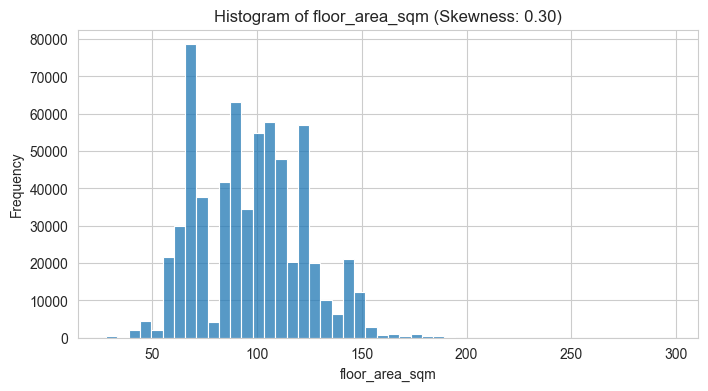

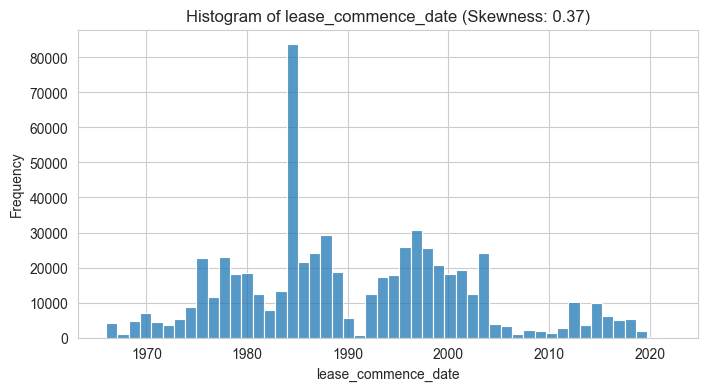

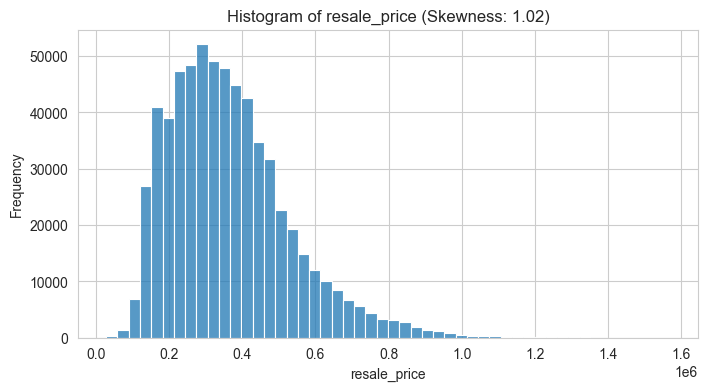

In [58]:
skewness_values = final_data[['floor_area_sqm', 'lease_commence_date','resale_price','average_storey','town','flat_type','flat_model']].skew()

# Print the skewness value for each column
print(skewness_values)

columns = ['floor_area_sqm', 'lease_commence_date','resale_price']

for col in columns:
    plt.figure(figsize=(8, 4))
    sb.histplot(final_data[col],bins=50, kde=False)
    plt.title(f'Histogram of {col} (Skewness: {skewness_values[col]:.2f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

## Histogram of log_resale_price

- **Description:** The histogram illustrates the distribution of the logarithm of `resale_price` values for properties.
- **Skewness:** -0.21, suggesting a slight left skew in the distribution. This skewness is closer to zero, which may indicate that the logarithmic transformation helped in achieving a distribution that approximates normality.
- **Observations:**
  - The distribution peaks around the 12.5 mark on the log scale of `resale_price`.
  - Frequencies taper off more gradually to the left of the peak than to the right, indicating a somewhat symmetrical distribution but with a slight tail to the lower end of prices.
  - This more symmetric distribution is typically preferred for many statistical methods and may indicate that the logarithmic transformation has mitigated the effect of extreme values or outliers.


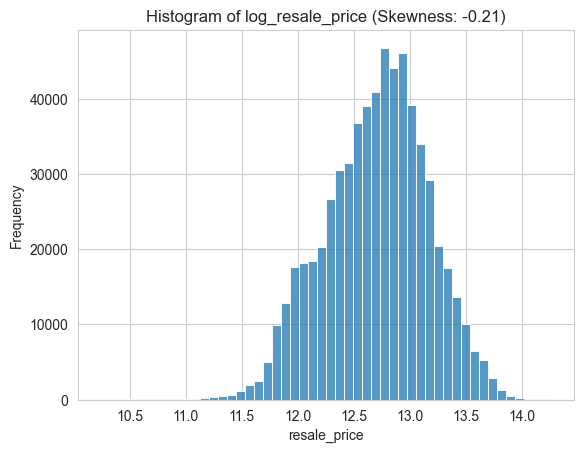

In [59]:
sb.histplot(np.log(final_data['resale_price']),bins=50, kde=False)
skewness_value = np.log(final_data['resale_price']).skew()
plt.title(f'Histogram of log_resale_price (Skewness: {skewness_value:.2f})')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.show()

## Histogram of Box-Cox Transformed 'resale_price'

- **Description:** This histogram presents the distribution of the Box-Cox transformed `resale_price` for a set of property data.
- **Skewness:** -0.01, indicating that the transformation has effectively normalized the distribution, resulting in a very symmetrical dataset about the mean.
- **Observations:**
  - The peak of the distribution is centered around the value of 40 on the Box-Cox scale, which is the most common range after the transformation.
  - The frequencies show a bell-shaped distribution, typical of a normal distribution, suggesting that the data is well-suited for various statistical analyses that assume normality.
  - There are no significant tails on either end of the distribution, further supporting the effectiveness of the Box-Cox transformation in stabilizing variance and making the data more symmetrical.


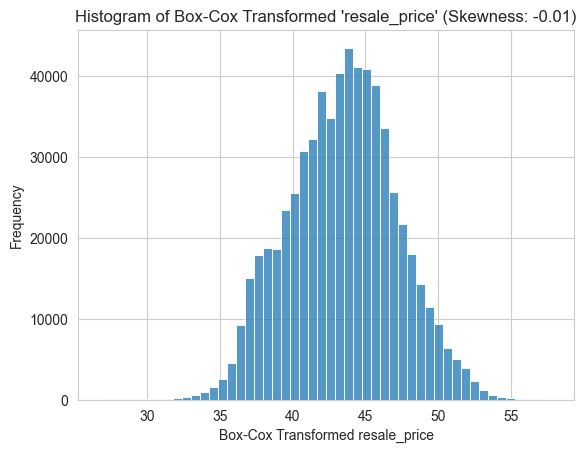

In [60]:
from scipy import stats

# Apply the Box-Cox transformation
resale_price_boxcox, _ = stats.boxcox(final_data['resale_price'])

# Plot the histogram of the Box-Cox transformed data
sb.histplot(resale_price_boxcox, bins=50, kde=False)

# Calculate the skewness after Box-Cox transformation
skewness_value_boxcox = pd.Series(resale_price_boxcox).skew()

# Title, xlabel, and ylabel for the plot
plt.title(f'Histogram of Box-Cox Transformed \'resale_price\' (Skewness: {skewness_value_boxcox:.2f})')
plt.xlabel('Box-Cox Transformed resale_price')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [61]:
final_data.to_csv('data/clean_data/final_data.csv',index=False)

In [62]:
import json

with open('data/clean_data/encoding_mappings.json', 'w') as fp:
    json.dump(encoding_mappings, fp)